In [1]:
# check tf, keras
import tensorflow as tf 
tf.compat.v1.experimental.output_all_intermediates(True)
import keras

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

import gym
import gym_anytrading

## recent version imports
from tensorflow.keras.optimizers import Adam
# import tensorflow_probability as tfp

if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.__version__)


Default GPU Device:/device:GPU:0
2.8.0


In [2]:
# import gym
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import keras
from sklearn.preprocessing import MinMaxScaler
np.random.seed(7)
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Bidirectional
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from gym import spaces
from gym.utils import seeding
from enum import Enum

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda, concatenate
from tensorflow.keras import backend as K
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory


In [3]:
root = 'C:/Users/Allen/Desktop/7773/Assignments/Final Project/'
#root = '/Users/anastasiya/Desktop/NYU Classes/Fall `22/7773/Final Project/Data/'

df_AA = pd.read_csv(root+'AA Full.csv', index_col = 'Date')
df_AA = df_AA[['Close', 'Open', 'High', 'Low', 'Volume']]


In [4]:
df_AA['Change']= df_AA['Close'].diff()
df_AA = df_AA.fillna(0)

In [5]:
pg1 = df_AA.copy(deep = True)

W%R 14 = [ H.HIGH - C.PRICE ] / [ L.LOW - C.PRICE ] * ( - 100 )
where,
W%R 14 = 14-day Williams %R of the stock
H.HIGH = 14-day Highest High of the stock
L.LOW = 14-day Lowest Low of the stock
C.PRICE = Closing price of the stock

IF PREV.W%R < [ - 20 ] AND CURRENT.W%R > [ - 20 ] ==> BUY SIGNAL
IF PREV.W%R > [ - 80 ] AND CURRENT.W%R < [ - 80 ] ==> SELL SIGNAL

In [6]:
class FinalDF():
    def __init__(self, df, span=14):
        self.df = df
        self.x_train = np.nan
        self.x_test = np.nan
        self.y_train = np.nan
        self.y_test = np.nan
        self.y_pred = np.nan
        self.model = Sequential()
    
    #@staticmethod
    def ema(self,span,col='Close', inplace = True):
        ser = self.df[col].ewm(span=span).mean()
        if inplace:
            self.df['ema'] = ser
        else: 
            return ser
    def add_WILLR(self, lookback_period):
        n = len(self.df)
        self.df['WILLR'] = np.nan
        for day in range(lookback_period+1,n):
            Close = self.df['Close'][day]
            HighestHigh = max(self.df['High'].iloc[day-lookback_period-1:day-1])
            LowestLow = min(self.df['Low'].iloc[day-lookback_period-1:day-1])
            willr = (HighestHigh - Close)/(HighestHigh - LowestLow) * (-100)
            self.df['WILLR'][day] = willr
    
    def add_RSI(self, lookback_period):
        n = len(self.df)
        df_hold = self.df.copy(deep = True)
        self.df['RSI'] = np.nan
        df_hold['Gain'] = 0
        df_hold['Loss'] = 0
        df_hold['Average_Gain'] = np.nan
        df_hold['Average_Loss'] = np.nan
        df_hold['RSI'] = np.nan
        df_hold['RS'] = np.nan
        for day in range(n):
            if df_hold['Change'][day] > 0:
                df_hold['Gain'][day] = df_hold['Change'][day]
                df_hold['Loss'][day] = 0
            else:
                df_hold['Loss'][day] = df_hold['Change'][day]*(-1)
                df_hold['Gain'][day] = 0

        for day in range(lookback_period+1,n):
            if day == lookback_period+1:
                df_hold['Average_Gain'][day] = np.mean(df_hold['Gain'].iloc[day-lookback_period-1:day-1])
                df_hold['Average_Loss'][day] = np.mean(df_hold['Loss'].iloc[day-lookback_period-1:day-1])
            else:
                df_hold['Average_Gain'][day] = (df_hold['Average_Gain'][day-1] * (lookback_period-1) + df_hold['Gain'][day])/ lookback_period
                df_hold['Average_Loss'][day] = (df_hold['Average_Loss'][day-1] * (lookback_period-1) + df_hold['Loss'][day])/ lookback_period
        df_hold['RS'] = df_hold['Average_Gain']/df_hold['Average_Loss']
        self.df['RSI'] = 100 - (100/(1+df_hold['RS']))
        
    def add_BIAS(self, lookback_period):
        n = len(self.df)
        self.df['BIAS'] = np.nan
        for day in range(lookback_period+1,n):
            ## do i look at days 1-14 and calculate day 15 or day 14?
            avg = np.mean(self.df['Close'].iloc[day-lookback_period-1:day-1])
            close = self.df['Close'][day]
            self.df['BIAS'][day] = ((close - avg)/avg)
    
    def add_KDJ(self, lookback_period):
        n = len(self.df)
        self.df['K'] = np.nan
        self.df['D'] = np.nan
        self.df['J'] = np.nan
        for day in range(lookback_period+1,n):
            if day == (lookback_period+1):
                self.df['K'][day] = 50
                self.df['D'][day] = 50
                self.df['J'][day] = 3*50 - 2*50
            else:
                Close = self.df['Close'][day]
                HighestHigh = max(self.df['High'].iloc[day-lookback_period-1:day-1])
                LowestLow = min(self.df['Low'].iloc[day-lookback_period-1:day-1])
                RSV = (Close - LowestLow)/(HighestHigh - LowestLow) * (100)
                self.df['K'][day] = 2/3 * self.df['K'][day-1] + 1/3 * RSV
                self.df['D'][day] = 2/3 * self.df['D'][day-1] + 1/3 * self.df['K'][day]
                self.df['J'][day] = 3*self.df['K'][day] - 2*self.df['D'][day]
        
    def add_indicators(self):
        ## add ema indicator
        self.ema(14)
        ## add diff indicator
        ema1 = self.ema(12, inplace=False)
        ema2 = self.ema(26, inplace=False)
        self.df['diff'] = ema1 - ema2
        ## add dea indicator
        self.df['dea'] = self.ema(14, col='diff', inplace=False)
        ## add macd indicator
        multiplier = 2 / (14 + 1)
        self.df['macd'] = (self.df['diff'] - self.df['dea']) * multiplier
        ## add WILLR indicator
        self.add_WILLR(14)
        self.add_RSI(14)
        self.add_BIAS(14)
        self.add_KDJ(14)
    
    def transform_data(self):
        mms = MinMaxScaler()
        hold = mms.fit_transform(self.df)
        self.df = pd.DataFrame(hold, index=self.df.index, columns=self.df.columns)
        self.df = self.df.fillna(0)
        
    def add_timesteps(self, dataset, time_steps):
        x = []
        y = []
        for i in range(time_steps, dataset.shape[0]):
            x.append(dataset[i - time_steps:i,:])
            y.append(dataset[i,:])
        return np.array(x), np.array(y)
    
    def get_train_test_data(self):
        train_ind = int(len(self.df) * 0.8)
        train, test = self.df.iloc[0:train_ind,:].to_numpy(), self.df.iloc[train_ind:,:].to_numpy()
        
        self.x_train, self.y_train = self.add_timesteps(train, 3)
        self.x_test, self.y_test = self.add_timesteps(test, 3)
        #return x_train, y_train, x_test, y_test
    
    def lstm_model(self, units):
        self.model = Sequential()
        self.model.add(layers.LSTM(units=units, activation='relu', return_sequences=True, input_shape=(self.x_train.shape[1], self.x_train.shape[2])))
        self.model.add(layers.LSTM(units=int(units / 2), activation='relu'))
        self.model.add(Dense(self.x_train.shape[2]))
        #model.summary()
        #tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
    
    def fit_lstm_model(self, epochs=50, batch_size=1):
        defined_metrics = [tf.keras.metrics.MeanSquaredError(name='MSE')]
        callback = tf.keras.callbacks.EarlyStopping(monitor="MSE", patience=3, mode='min', verbose=1)
        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=defined_metrics)
        history = self.model.fit(self.x_train, self.y_train, epochs=epochs, batch_size=batch_size, callbacks=[callback])

    def predict_lstm(self):
        self.y_pred = self.model.predict(self.x_test)
        
    def get_mse(self):
        return mean_squared_error(self.y_test, self.y_pred)

In [39]:
tst3 = pg1.iloc[0:int(len(pg1)*0.8)]


In [9]:
aa = FinalDF(tst3)
aa.add_indicators()
aa.transform_data()
aa.get_train_test_data()
aa.lstm_model(128)
aa.fit_lstm_model()
aa.predict_lstm()

Train on 869 samples
Epoch 1/50
869/869 [==============================] - 12s 12ms/sample - loss: 0.0146 - MSE: 0.0146
Epoch 2/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0045 - MSE: 0.0045
Epoch 3/50
869/869 [==============================] - 11s 12ms/sample - loss: 0.0036 - MSE: 0.0036
Epoch 4/50
869/869 [==============================] - 11s 12ms/sample - loss: 0.0032 - MSE: 0.0032
Epoch 5/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0029 - MSE: 0.0029
Epoch 6/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0029 - MSE: 0.0029
Epoch 7/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0028 - MSE: 0.0028
Epoch 8/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0026 - MSE: 0.0026
Epoch 9/50
869/869 [==============================] - 10s 12ms/sample - loss: 0.0027 - MSE: 0.0027
Epoch 10/50
869/869 [==============================] - 8s 9ms/sample - loss: 0.0026 - MS

In [13]:
aa.get_mse()

0.003067030715492353

In [14]:
aa.y_pred.shape

(215, 16)

In [22]:
aaT = aa.y_pred.T
aaTest = aa.y_test.T

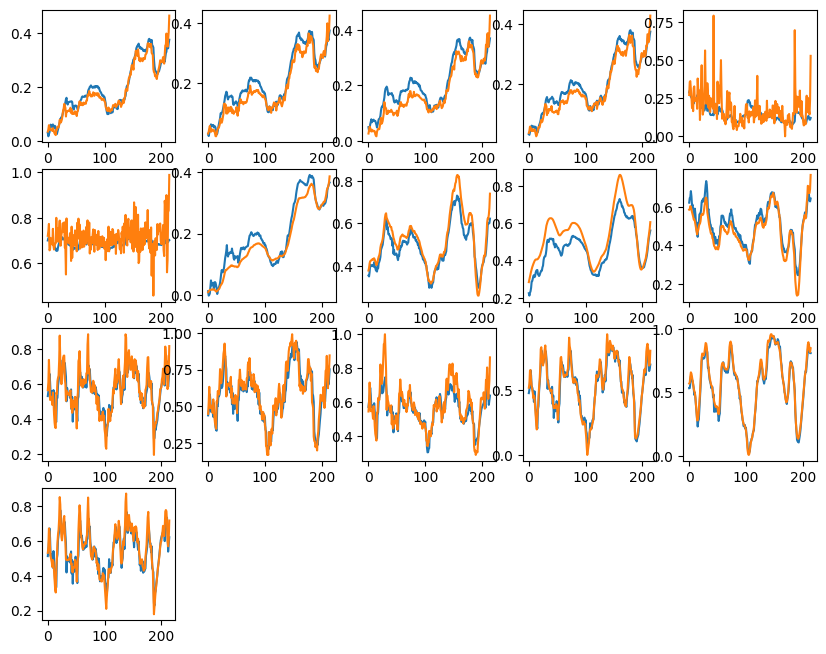

In [27]:
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(5,5,i+1)
    plt.plot(aaT[i])
    plt.plot(aaTest[i])
plt.show();


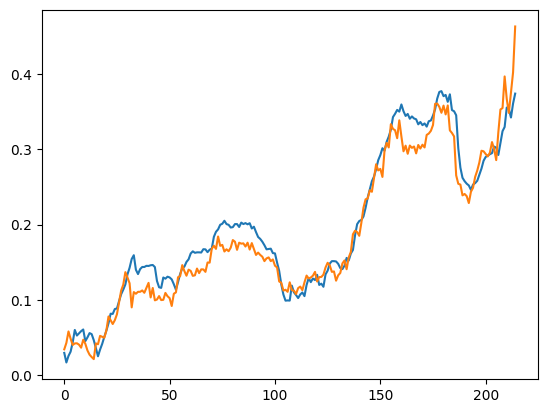

In [31]:
plt.plot(aaT[0])
plt.plot(aaTest[0])


In [45]:
np.sum((aaT[0] - aaTest[0]) ** 2) / 215


0.000578865105359005

In [48]:
aaTest[0].std() / np.sqrt(215)


0.006599855219637205

array([0.03452055, 0.04310502, 0.05826484, 0.04876712, 0.0403653 ,
       0.04237443, 0.04255708, 0.04073059, 0.03671233, 0.04730594,
       0.04182648, 0.03305936, 0.02739726, 0.02429224, 0.02155251,
       0.04237443, 0.04127854, 0.05242009, 0.05114155, 0.04986301,
       0.05990868, 0.07817352, 0.07305936, 0.06812785, 0.07324201,
       0.08109589, 0.096621  , 0.11251142, 0.1203653 , 0.1369863 ,
       0.12986301, 0.12219178, 0.09022831, 0.11050228, 0.1083105 ,
       0.11086758, 0.11086758, 0.11269406, 0.10958904, 0.11598174,
       0.12273973, 0.103379  , 0.11598174, 0.09954338, 0.10063927,
       0.10520548, 0.09990868, 0.10027397, 0.10940639, 0.10502283,
       0.10246575, 0.09205479, 0.1083105 , 0.11013699, 0.13022831,
       0.1316895 , 0.14630137, 0.13844749, 0.13223744, 0.14027397,
       0.13863014, 0.13205479, 0.13278539, 0.14173516, 0.13570776,
       0.14063927, 0.14063927, 0.1373516 , 0.14977169, 0.14958904,
       0.16803653, 0.17205479, 0.16785388, 0.18429224, 0.17187

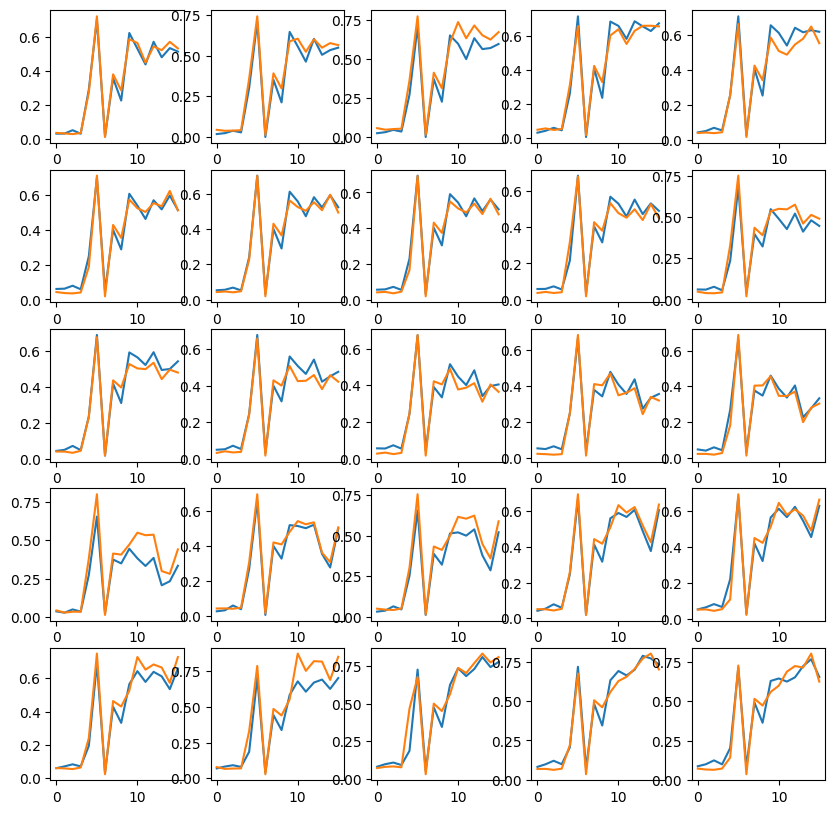

In [12]:
# plt.figure(figsize=(10,10))
# for i in range(25):
#     plt.subplot(5,5,i+1)
#     plt.plot(aa.y_pred[i])
#     plt.plot(aa.y_test[i])
# plt.show();


https://github.com/keras-rl/keras-rl/blob/master/examples/duel_dqn_cartpole.py


https://github.com/AminHP/gym-anytrading/blob/master/gym_anytrading/envs/trading_env.py

In [12]:
# env = gym.make('stocks-v0',
#                df = aa.df,
#                window_size = 30,
#                frame_bound = (30, len(aa.df)))
# np.random.seed(123)
# env.seed(123)
# nb_actions = env.action_space.n


In [13]:
train_env = gym.make('stocks-v0',
               df = aa.df[:1000],
               window_size = 30,
               frame_bound = (30, len(aa.df)))

test_env = gym.make('stocks-v0',
               df = aa.df[1000:],
               window_size = 30,
               frame_bound = (30, len(aa.df)))


np.random.seed(123)
train_env.seed(123)
nb_actions = train_env.action_space.n


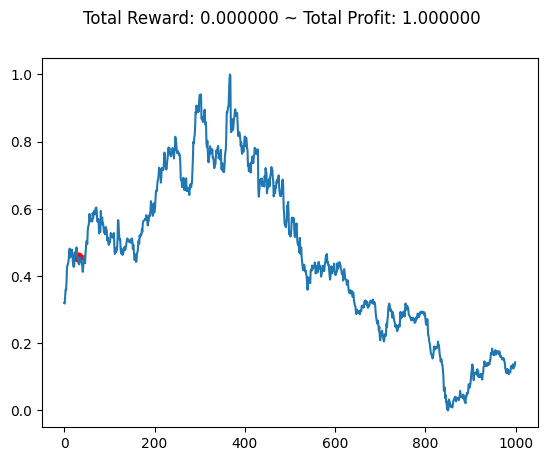

In [14]:
train_env.reset()
train_env.render()

In [15]:
# Next, we build a very simple model regardless of the dueling architecture
# if you enable dueling network in DQN , DQN will build a dueling network base on your model automatically
# Also, you can build a dueling network by yourself and turn off the dueling network in DQN.

dmodel = Sequential()
dmodel.add(layers.Flatten(input_shape=(1,) + train_env.observation_space.shape)) # obs space shape = (30,2), makes sense
dmodel.add(Dense(16))
dmodel.add(Activation('relu'))
dmodel.add(Dense(16))
dmodel.add(Activation('relu'))
dmodel.add(Dense(16))
dmodel.add(Activation('relu'))
dmodel.add(Dense(nb_actions, activation='linear'))
print(dmodel.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                976       
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)               

In [16]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=50000, window_length=1)
policy = BoltzmannQPolicy()


In [17]:
# enable the dueling network
# you can specify the dueling_type to one of {'avg','max','naive'}
dqn = DQNAgent(model=dmodel, nb_actions=nb_actions, memory=memory, nb_steps_warmup=50, 
               enable_dueling_network=True, dueling_type='naive', target_model_update=1e-2, policy=policy, 
               enable_double_dqn=True)
dqn.compile(Adam(lr=1e-4), metrics=['mae'])


In [18]:
# # Okay, now it's time to learn something! We visualize the training here for show, but this
# # slows down training quite a lot. You can always safely abort the training prematurely using
# # Ctrl + C.
# dqn.fit(train_env, nb_steps=50000, visualize=False, verbose=2)

# # After training is done, we save the final weights.
# dqn.save_weights('duel_dqn_{}_weights.h5f'.format('test'), overwrite=True)

# # Finally, evaluate our algorithm for 5 episodes.
# dqn.test(train_env, nb_episodes=5, visualize=True)

In [19]:
dqn.fit(train_env, nb_steps=50000, visualize=False, verbose=2)
dqn.save_weights('duel_dqn_{}_weights.h5f'.format('test'), overwrite=True)
history_train = train_env.history
history_test = None

Training for 50000 steps ...
   969/50000: episode: 1, duration: 8.376s, episode steps: 969, steps per second: 116, episode reward: -0.102, mean reward: -0.000 [-0.148,  0.081], mean action: 0.494 [0.000, 1.000],  loss: 0.000317, mae: 0.099809, mean_q: 0.189921
  1938/50000: episode: 2, duration: 7.633s, episode steps: 969, steps per second: 127, episode reward: -0.199, mean reward: -0.000 [-0.137,  0.089], mean action: 0.503 [0.000, 1.000],  loss: 0.000119, mae: 0.089835, mean_q: 0.172596
  2907/50000: episode: 3, duration: 7.761s, episode steps: 969, steps per second: 125, episode reward: -0.277, mean reward: -0.000 [-0.148,  0.121], mean action: 0.491 [0.000, 1.000],  loss: 0.000100, mae: 0.088681, mean_q: 0.171138
  3876/50000: episode: 4, duration: 7.706s, episode steps: 969, steps per second: 126, episode reward: -0.131, mean reward: -0.000 [-0.157,  0.062], mean action: 0.517 [0.000, 1.000],  loss: 0.000097, mae: 0.087303, mean_q: 0.168653
  4845/50000: episode: 5, duration: 7.6

 34884/50000: episode: 36, duration: 8.204s, episode steps: 969, steps per second: 118, episode reward: -0.433, mean reward: -0.000 [-0.137,  0.116], mean action: 0.489 [0.000, 1.000],  loss: 0.000104, mae: 0.080900, mean_q: 0.155631
 35853/50000: episode: 37, duration: 8.135s, episode steps: 969, steps per second: 119, episode reward: -0.023, mean reward: -0.000 [-0.077,  0.062], mean action: 0.522 [0.000, 1.000],  loss: 0.000102, mae: 0.081259, mean_q: 0.156334
 36822/50000: episode: 38, duration: 8.221s, episode steps: 969, steps per second: 118, episode reward: -0.146, mean reward: -0.000 [-0.140,  0.082], mean action: 0.523 [0.000, 1.000],  loss: 0.000096, mae: 0.080864, mean_q: 0.155637
 37791/50000: episode: 39, duration: 8.175s, episode steps: 969, steps per second: 119, episode reward: -0.076, mean reward: -0.000 [-0.137,  0.075], mean action: 0.509 [0.000, 1.000],  loss: 0.000098, mae: 0.080527, mean_q: 0.154988
 38760/50000: episode: 40, duration: 8.242s, episode steps: 969,

In [20]:
observation = test_env.reset()
dqn.test(test_env, nb_episodes=5, visualize=False)
history_test = test_env.history

Testing for 5 episodes ...
Episode 1: reward: 0.062, steps: 59
Episode 2: reward: 0.062, steps: 59
Episode 3: reward: 0.062, steps: 59
Episode 4: reward: 0.062, steps: 59
Episode 5: reward: 0.062, steps: 59
